# Imports 

## Pakages

In [1]:
# Data Handling
import numpy as np
import pandas as pd

# Data Visualization
import matplotlib.pyplot as plt
import seaborn as sns

# Utils
import os
import jdatetime
import copy
from sklearn.metrics import mean_squared_error, r2_score
import tensorflow as tf

# Models
import xgboost as xgb
from tensorflow.keras.models import Sequential, Model
from tensorflow.keras import layers, optimizers, metrics, losses
from sklearn.linear_model import LinearRegression as LR

In [2]:
tf.__version__

'2.10.0'

In [3]:
tf.config.list_physical_devices()

[PhysicalDevice(name='/physical_device:CPU:0', device_type='CPU'),
 PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]

## Notebook Config

In [4]:
class cfg:
    base_dir = os.getcwd()
    data_dir = f'{os.getcwd()}\\Data\\DC-DATA.xlsx'
    validation_phase = True
    color = sns.color_palette()
    split_date = '1401-11-01'

## Helper Functions

In [5]:
def str2date(obj):
    splitted = obj.split('-')
    y, m, d = int(splitted[0]), int(splitted[1]), int(splitted[2])
    return jdatetime.date(year=y, month=m, day=d)

def create_features(df):
    vfunc = np.vectorize(str2date)
    jdt_format = vfunc(df.index.values)
    func = lambda t:(t.day, t.month, t.year)
    vfunc = np.vectorize(func)
    return vfunc(jdt_format)

## Reading Data

In [6]:
df = pd.read_excel(cfg.data_dir)
df.tail()

,شماره سفارش,تاریخ ایجاد سفارش,وزن (کیلوگرم),استان فرستنده,شهر فرستنده,استان گیرنده,شهر گیرنده
384259,10118717190559,1401-10-01,1.0,کردستان,بانه,اصفهان,کاشان
384260,10118717190583,1401-10-01,18.0,کردستان,مریوان,تهران,تهران
384261,10118717190968,1401-10-01,3.0,کردستان,مریوان,تهران,تهران
384262,10118717191597,1401-10-01,3.0,آذربایجان غربی,ارومیه,تهران,تهران
384263,10118717190746,1401-10-01,0.5,خوزستان,اهواز,تهران,تهران


In [7]:
df.shape

(384264, 7)

# Preping Data

In [8]:
df = df.iloc[:, 0:2]   # we dont need other columns
df.columns = ['count', 'date']
#df.date = df.date.apply(str2date)
df.head()

,count,date
0,10118717188857,1401-09-30
1,10118717187382,1401-09-30
2,10118717187505,1401-09-30
3,10118717189304,1401-09-30
4,10118717189323,1401-09-30


In [9]:
gdf = df.groupby(['date']).count()
gdf.head()

,count
date,
1401-01-01,12
1401-01-02,20
1401-01-03,26
1401-01-04,15
1401-01-05,59


In [10]:
gdf.shape

(365, 1)

### Visualizing 

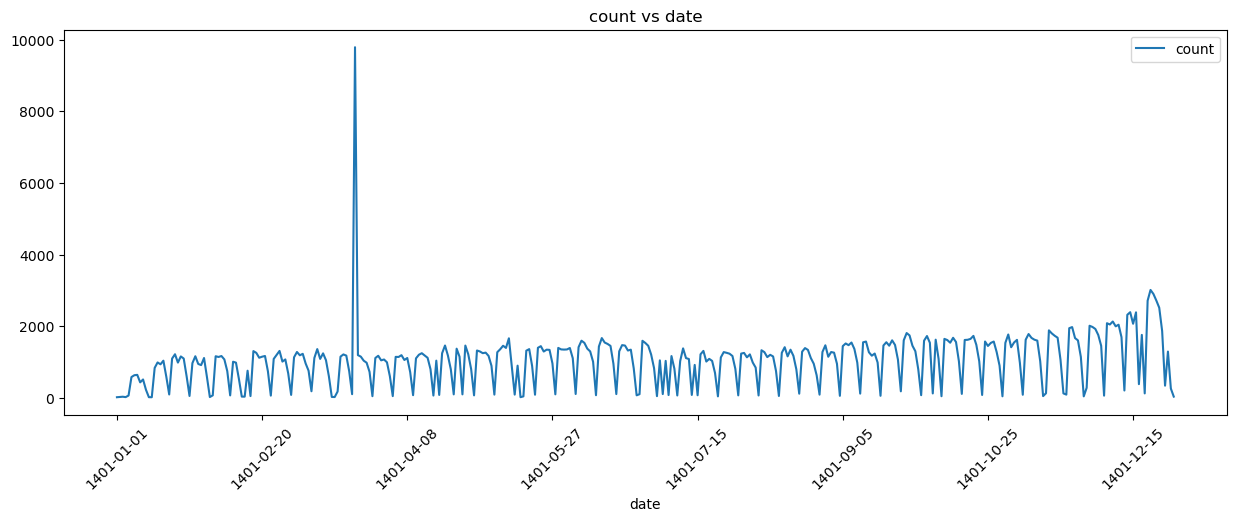

In [11]:
gdf.plot(figsize=(15,5), color=cfg.color[0], title='count vs date')
plt.xticks(rotation = 45)
plt.show()

- seems we have an outlier its highly unlikely that we had this many orders in a single day, so we need to find out what caused it.
- for now i'm going to impute its new value by averaging neighbors.

In [12]:
print(gdf.idxmax())
gdf.iloc[np.argmax(gdf)] = np.mean([gdf.iloc[np.argmax(gdf)-1], gdf.iloc[np.argmax(gdf)+1]])

count    1401-03-21
dtype: object


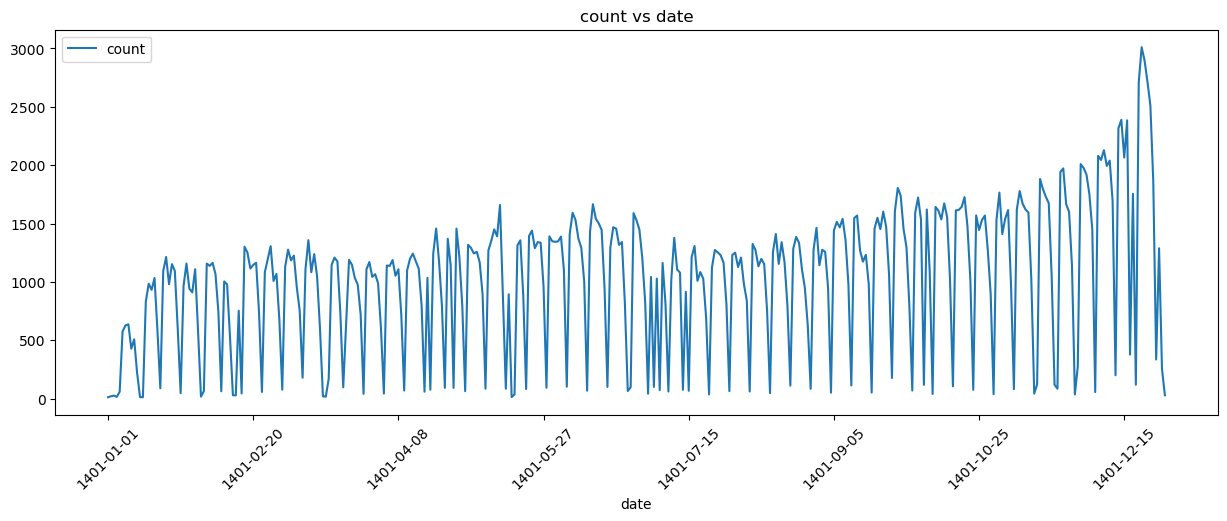

In [13]:
gdf.plot(figsize=(15,5), color=cfg.color[0], title='count vs date')
plt.xticks(rotation = 45)
plt.show()

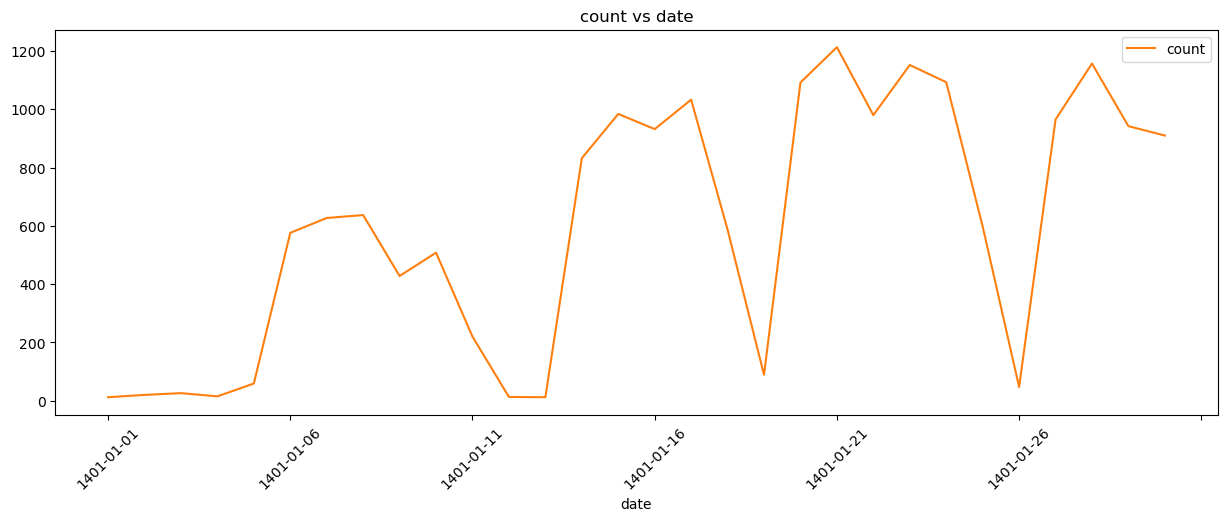

In [14]:
gdf.iloc[0:30].plot(figsize=(15,5), color=cfg.color[1], title='count vs date')
plt.xticks(rotation = 45)
plt.show()

- the data is weekly seasonal with a slight upward trend towards the end of the year
- the data probably is yearly seasonal but since we have only access to one year of data we cant do anything about it

we can have 3 approaches to solve this problem:
- using statistical forcasting (moving avg, etc)
- treating data as structured data and create #week, #day_of_week, etc features
- treating data as sequence data

here im going to try last two approaches

# Method 2

In [15]:
day_of_month, month, year = create_features(gdf)
day_of_week = (day_of_month+1)%7 # saturday is 0 and friday is 6
week = np.array(range(2,367))//7 + 1
m2_df = copy.deepcopy(gdf)
for feat, name in zip([day_of_month,month,day_of_week,week], ['day_of_month','month','day_of_week','week']):
    m2_df[name] = feat

In [16]:
m2_df.head(10)

,count,day_of_month,month,day_of_week,week
date,,,,,
1401-01-01,12,1,1,2,1
1401-01-02,20,2,1,3,1
1401-01-03,26,3,1,4,1
1401-01-04,15,4,1,5,1
1401-01-05,59,5,1,6,1
1401-01-06,576,6,1,0,2
1401-01-07,627,7,1,1,2
1401-01-08,637,8,1,2,2
1401-01-09,428,9,1,3,2


In [17]:
m2_df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 365 entries, 1401-01-01 to 1401-12-29
Data columns (total 5 columns):
 #   Column        Non-Null Count  Dtype
---  ------        --------------  -----
 0   count         365 non-null    int64
 1   day_of_month  365 non-null    int32
 2   month         365 non-null    int32
 3   day_of_week   365 non-null    int32
 4   week          365 non-null    int32
dtypes: int32(4), int64(1)
memory usage: 11.4+ KB


## Train/Val Split

In [18]:
if cfg.validation_phase:
    # splitting last two month as validation set -- ref--> cfg.split_date
    m2_train_df = m2_df.loc[cfg.split_date>m2_df.index]
    m2_eval_df = m2_df.loc[cfg.split_date<=m2_df.index]
    
    m2_train_x = m2_train_df.drop(['count'], axis=1)
    m2_train_y = m2_train_df['count']
    
    m2_eval_x = m2_eval_df.drop(['count'], axis=1)
    m2_eval_y = m2_eval_df['count']
else:
    m2_train_df = m2_df.copy()
    m2_train_x = m2_train_df.drop(['count'], axis=1)
    m2_train_y = m2_train_df['count']

In [19]:
m2_train_x.values.shape

(306, 4)

# Method 3

In [20]:
window_size = 28

In [21]:
m3_ds = tf.data.Dataset.from_tensor_slices(gdf.values[:,0])
m3_ds = m3_ds.window(size=window_size, shift=1, drop_remainder=True)
m3_ds = m3_ds.flat_map(lambda window: window.batch(window_size))
m3_ds = m3_ds.map(lambda window: (window[:-1], window[-1]))
#m3_ds = m3_ds.shuffle(buffer_size=10)
#m3_ds = m3_ds.batch(2).prefetch(1)
feat = []
labels = []
for x,y in m3_ds:
    feat.append(x.numpy())
    labels.append(y.numpy())
feat = np.array(feat)
labels = np.array(labels)

In [22]:
feat.shape

(338, 27)

In [23]:
m3_df = gdf.iloc[-feat.shape[0]:].copy()
for i in range(feat.shape[1]):
    m3_df[f'Target-{window_size-i-1}'] = feat[:,i]

In [24]:
m3_df.tail()

,count,Target-27,Target-26,Target-25,Target-24,Target-23,Target-22,Target-21,Target-20,Target-19,...,Target-10,Target-9,Target-8,Target-7,Target-6,Target-5,Target-4,Target-3,Target-2,Target-1
date,,,,,,,,,,,,,,,,,,,,,
1401-12-25,1863,36,275,2009,1976,1919,1751,1449,56,2080,...,2065,2384,377,1754,119,2710,3010,2897,2714,2513
1401-12-26,335,275,2009,1976,1919,1751,1449,56,2080,2044,...,2384,377,1754,119,2710,3010,2897,2714,2513,1863
1401-12-27,1288,2009,1976,1919,1751,1449,56,2080,2044,2128,...,377,1754,119,2710,3010,2897,2714,2513,1863,335
1401-12-28,255,1976,1919,1751,1449,56,2080,2044,2128,1993,...,1754,119,2710,3010,2897,2714,2513,1863,335,1288
1401-12-29,29,1919,1751,1449,56,2080,2044,2128,1993,2039,...,119,2710,3010,2897,2714,2513,1863,335,1288,255


## Train/Val split

In [25]:
if cfg.validation_phase:
    # splitting last two month as validation set -- ref--> cfg.split_date
    m3_train_df = m3_df.loc[cfg.split_date>m3_df.index]
    m3_eval_df = m3_df.loc[cfg.split_date<=m3_df.index]
    
    m3_train_dates = m3_train_df.index.values
    m3_train_x = m3_train_df.drop(['count'], axis=1).values.reshape(len(m3_train_dates), window_size-1).astype(np.float32)
    m3_train_y = m3_train_df['count'].astype(np.float32)
    
    m3_eval_dates = m3_eval_df.index.values
    m3_eval_x = m3_eval_df.drop(['count'], axis=1).values.reshape(len(m3_eval_dates), window_size-1).astype(np.float32)
    m3_eval_y = m3_eval_df['count'].astype(np.float32)
else:
    m3_train_df = m3_df.copy()
    m3_train_dates = m3_train_df.index.values
    m3_train_x = m3_train_df.drop(['count'], axis=1).values.reshape(len(m3_train_dates), window_size-1).astype(np.float32)
    m3_train_y = m3_train_df['count'].astype(np.float32)
    
    

In [26]:
m3_train_x.shape, m3_train_y.shape

((279, 27), (279,))

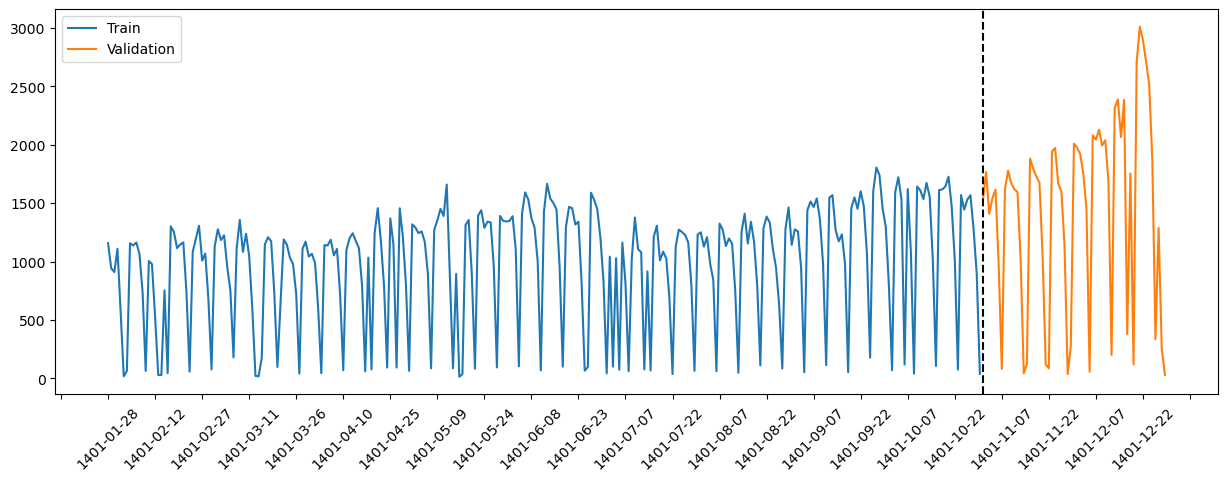

In [27]:
f, ax = plt.subplots(figsize=(15,5))
ax.plot(m3_train_dates, m3_train_y)
if cfg.validation_phase:
    ax.plot(m3_eval_dates, m3_eval_y)
    ax.axvline(x=cfg.split_date, color='black', ls='--')
ax.xaxis.set_major_locator(plt.MaxNLocator(30))
plt.xticks(rotation=45)
plt.legend(['Train', 'Validation'])
plt.show()

# MIX of M2 and M3

In [28]:
m4_df = pd.concat([m2_df,m3_df.drop(['count'],axis=1)], axis=1)

In [29]:
idx = (1-m4_df['Target-1'].isna()).astype(np.bool_)
m4_df = m4_df.loc[idx]
m4_df

,count,day_of_month,month,day_of_week,week,Target-27,Target-26,Target-25,Target-24,Target-23,...,Target-10,Target-9,Target-8,Target-7,Target-6,Target-5,Target-4,Target-3,Target-2,Target-1
date,,,,,,,,,,,,,,,,,,,,,
1401-01-28,1157,28,1,1,5,12.0,20.0,26.0,15.0,59.0,...,587.0,89.0,1092.0,1213.0,980.0,1152.0,1093.0,598.0,47.0,965.0
1401-01-29,942,29,1,2,5,20.0,26.0,15.0,59.0,576.0,...,89.0,1092.0,1213.0,980.0,1152.0,1093.0,598.0,47.0,965.0,1157.0
1401-01-30,910,30,1,3,5,26.0,15.0,59.0,576.0,627.0,...,1092.0,1213.0,980.0,1152.0,1093.0,598.0,47.0,965.0,1157.0,942.0
1401-01-31,1108,31,1,4,5,15.0,59.0,576.0,627.0,637.0,...,1213.0,980.0,1152.0,1093.0,598.0,47.0,965.0,1157.0,942.0,910.0
1401-02-01,577,1,2,2,5,59.0,576.0,627.0,637.0,428.0,...,980.0,1152.0,1093.0,598.0,47.0,965.0,1157.0,942.0,910.0,1108.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1401-12-25,1863,25,12,5,52,36.0,275.0,2009.0,1976.0,1919.0,...,2065.0,2384.0,377.0,1754.0,119.0,2710.0,3010.0,2897.0,2714.0,2513.0
1401-12-26,335,26,12,6,52,275.0,2009.0,1976.0,1919.0,1751.0,...,2384.0,377.0,1754.0,119.0,2710.0,3010.0,2897.0,2714.0,2513.0,1863.0
1401-12-27,1288,27,12,0,53,2009.0,1976.0,1919.0,1751.0,1449.0,...,377.0,1754.0,119.0,2710.0,3010.0,2897.0,2714.0,2513.0,1863.0,335.0


In [30]:
m3_df.shape

(338, 28)

## Train/Val split

In [31]:
if cfg.validation_phase:
    # splitting last two month as validation set -- ref--> cfg.split_date
    m4_train_df = m4_df.loc[cfg.split_date>m4_df.index]
    m4_eval_df = m4_df.loc[cfg.split_date<=m4_df.index]
    
    m4_train_dates = m4_train_df.index.values
    m4_train_x = m4_train_df.drop(['count'], axis=1).values.astype(np.float32)
    m4_train_y = m4_train_df['count'].astype(np.float32)
    
    m4_eval_dates = m4_eval_df.index.values
    m4_eval_x = m4_eval_df.drop(['count'], axis=1).values.astype(np.float32)
    m4_eval_y = m4_eval_df['count'].astype(np.float32)
else:
    m4_train_df = m4_df.copy()
    m4_train_dates = m4_train_df.index.values
    m4_train_x = m4_train_df.drop(['count'], axis=1).values.astype(np.float32)
    m4_train_y = m4_train_df['count'].astype(np.float32)
    
    

# Models

   ## Linear Regression

In [32]:
lr = LR()
lr.fit(m2_train_x, m2_train_y.values)

LinearRegression()

In [33]:
p_train = lr.predict(m2_train_x)
if cfg.validation_phase:
    p_eval = lr.predict(m2_eval_x)


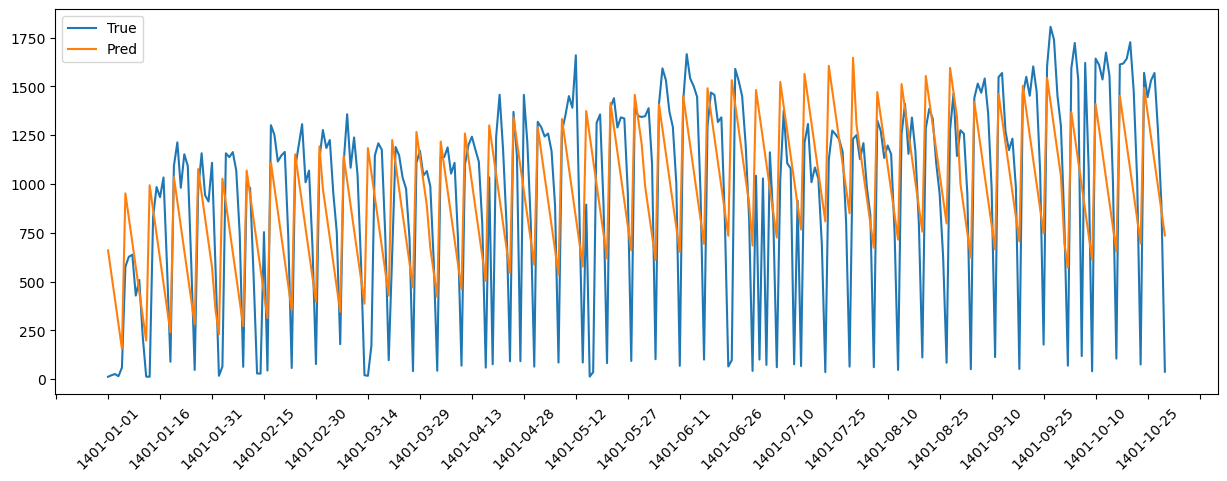

In [34]:
f, ax = plt.subplots(figsize=(15,5))
ax.plot(m2_train_x.index, m2_train_y)
ax.plot(m2_train_x.index, p_train)
ax.xaxis.set_major_locator(plt.MaxNLocator(30))
plt.xticks(rotation=45)
plt.legend(['True', 'Pred'])
plt.show()

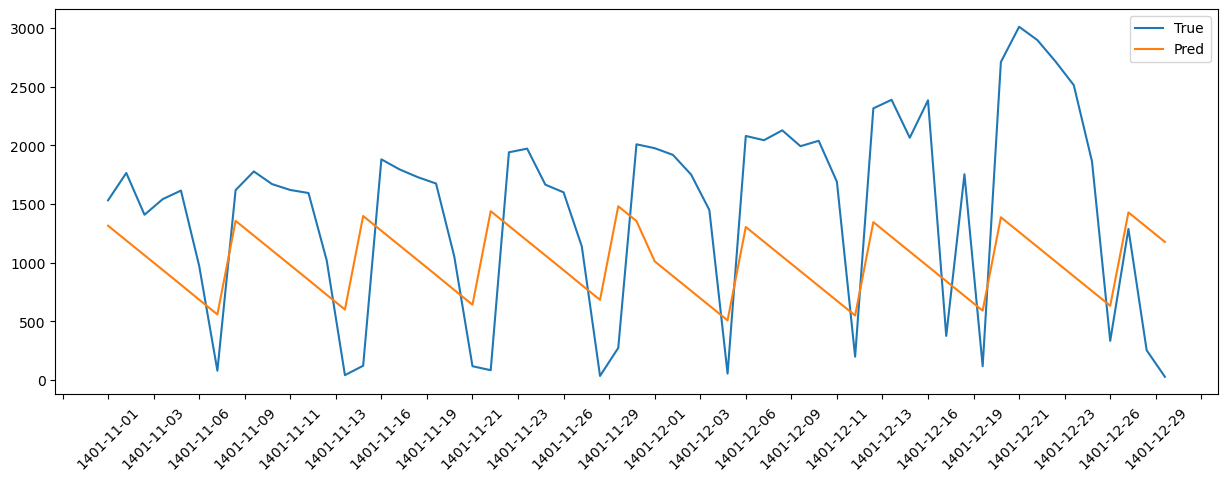

In [35]:
if cfg.validation_phase:
    f, ax = plt.subplots(figsize=(15,5))
    ax.plot(m2_eval_x.index, m2_eval_y)
    ax.plot(m2_eval_x.index, p_eval)
    ax.xaxis.set_major_locator(plt.MaxNLocator(30))
    plt.xticks(rotation=45)
    plt.legend(['True', 'Pred'])
    plt.show()

In [36]:
np.sqrt(mean_squared_error(p_eval, m2_eval_y))

901.145070737606

## XGBoost 

### Using M2 Data

In [37]:
# model config
n_estimators = 5000
es = 20
lr = 0.01
verbosity = True
if cfg.validation_phase:
    eval_set = [(m2_train_x, m2_train_y), (m2_eval_x, m2_eval_y)]
else:
    eval_set = [(m2_train_x, m2_train_y)]

In [38]:
xgbr = xgb.XGBRegressor(n_estimators=n_estimators, early_stopping_rounds=es, learning_rate=lr)
xgbr.fit(m2_train_x, m2_train_y,
        eval_set=eval_set,
        verbose=verbosity)

[0]	validation_0-rmse:1067.44508	validation_1-rmse:1662.66059
[1]	validation_0-rmse:1058.72938	validation_1-rmse:1653.00796
[2]	validation_0-rmse:1050.11277	validation_1-rmse:1643.47674
[3]	validation_0-rmse:1041.59440	validation_1-rmse:1634.06586
[4]	validation_0-rmse:1033.17328	validation_1-rmse:1624.77388
[5]	validation_0-rmse:1024.84849	validation_1-rmse:1615.59973
[6]	validation_0-rmse:1016.61925	validation_1-rmse:1606.54202
[7]	validation_0-rmse:1008.48470	validation_1-rmse:1597.59964
[8]	validation_0-rmse:1000.44385	validation_1-rmse:1588.77136
[9]	validation_0-rmse:992.48321	validation_1-rmse:1580.05590
[10]	validation_0-rmse:984.61513	validation_1-rmse:1571.45215
[11]	validation_0-rmse:976.83884	validation_1-rmse:1562.95884
[12]	validation_0-rmse:968.92993	validation_1-rmse:1555.40173
[13]	validation_0-rmse:961.38103	validation_1-rmse:1546.64067
[14]	validation_0-rmse:953.86832	validation_1-rmse:1538.46602
[15]	validation_0-rmse:946.20959	validation_1-rmse:1531.22937
[16]	vali

[132]	validation_0-rmse:426.24619	validation_1-rmse:1142.43329
[133]	validation_0-rmse:423.77556	validation_1-rmse:1141.54969
[134]	validation_0-rmse:421.30972	validation_1-rmse:1140.68483
[135]	validation_0-rmse:419.12497	validation_1-rmse:1139.65112
[136]	validation_0-rmse:417.13226	validation_1-rmse:1139.10750
[137]	validation_0-rmse:414.77598	validation_1-rmse:1138.29717
[138]	validation_0-rmse:412.66450	validation_1-rmse:1137.31752
[139]	validation_0-rmse:410.40327	validation_1-rmse:1136.54209
[140]	validation_0-rmse:408.10758	validation_1-rmse:1135.78357
[141]	validation_0-rmse:405.99529	validation_1-rmse:1134.56914
[142]	validation_0-rmse:403.72455	validation_1-rmse:1134.21896
[143]	validation_0-rmse:401.74837	validation_1-rmse:1133.32718
[144]	validation_0-rmse:399.79899	validation_1-rmse:1132.45152
[145]	validation_0-rmse:397.58632	validation_1-rmse:1132.14165
[146]	validation_0-rmse:395.34881	validation_1-rmse:1131.03858
[147]	validation_0-rmse:393.13937	validation_1-rmse:112

XGBRegressor(base_score=None, booster=None, callbacks=None,
             colsample_bylevel=None, colsample_bynode=None,
             colsample_bytree=None, early_stopping_rounds=20,
             enable_categorical=False, eval_metric=None, feature_types=None,
             gamma=None, gpu_id=None, grow_policy=None, importance_type=None,
             interaction_constraints=None, learning_rate=0.01, max_bin=None,
             max_cat_threshold=None, max_cat_to_onehot=None,
             max_delta_step=None, max_depth=None, max_leaves=None,
             min_child_weight=None, missing=nan, monotone_constraints=None,
             n_estimators=5000, n_jobs=None, num_parallel_tree=None,
             predictor=None, random_state=None, ...)

In [39]:
if cfg.validation_phase:
    predict = xgbr.predict(m2_eval_x)
else:
    predict = xgbr.predict(m2_train_x)

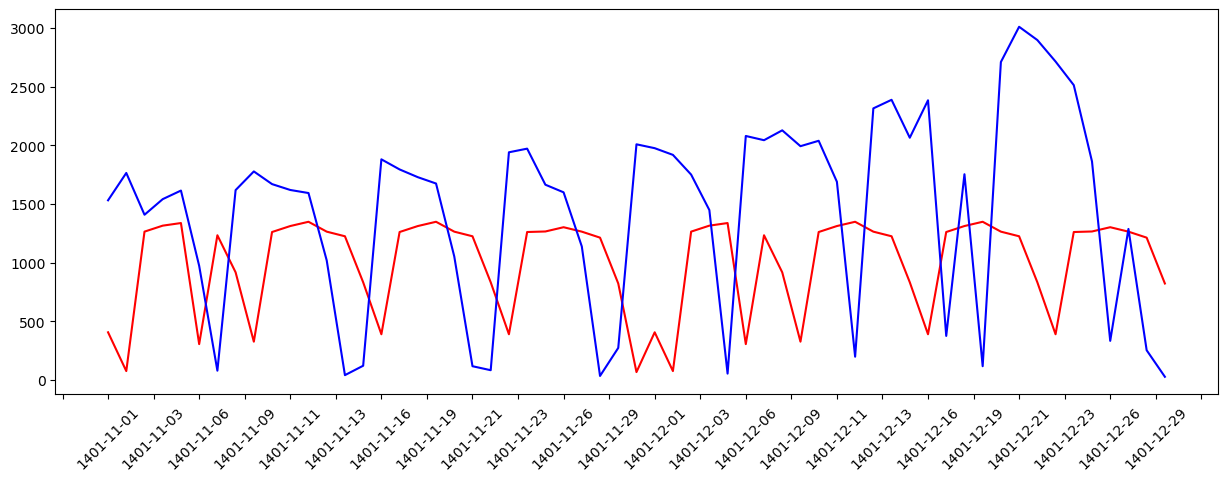

In [40]:
f, ax = plt.subplots(figsize=(15,5))
if cfg.validation_phase:
    ax.plot(m2_eval_x.index, predict, color='r')
    ax.plot(m2_eval_x.index, m2_eval_y, color='b')
else:
    ax.plot(m2_train_x.index, predict, color='r')
    ax.plot(m2_train_x.index, m2_train_y, color='b')

ax.xaxis.set_major_locator(plt.MaxNLocator(30))
plt.xticks(rotation = 45)
plt.show()

as expected this model captured seasonality but not the upward trend

### using M3 Data

In [41]:
# model config
n_estimators = 5000
es = 20
lr = 0.01
verbosity = True
if cfg.validation_phase:
    eval_set = [(m3_train_x, m3_train_y), (m3_eval_x, m3_eval_y)]
else:
    eval_set = [(m3_train_x, m3_train_y)]

In [42]:
xgbr = xgb.XGBRegressor(n_estimators=n_estimators, early_stopping_rounds=es, learning_rate=lr)
xgbr.fit(m3_train_x, m3_train_y,
        eval_set=eval_set,
        verbose=verbosity)

[0]	validation_0-rmse:1095.91559	validation_1-rmse:1662.41205
[1]	validation_0-rmse:1085.55717	validation_1-rmse:1652.80565
[2]	validation_0-rmse:1075.30317	validation_1-rmse:1643.31184
[3]	validation_0-rmse:1065.25201	validation_1-rmse:1633.62333
[4]	validation_0-rmse:1055.20200	validation_1-rmse:1624.34582
[5]	validation_0-rmse:1045.25100	validation_1-rmse:1615.18727
[6]	validation_0-rmse:1035.40438	validation_1-rmse:1605.62191
[7]	validation_0-rmse:1025.65738	validation_1-rmse:1596.16206
[8]	validation_0-rmse:1016.00540	validation_1-rmse:1587.30800
[9]	validation_0-rmse:1006.45389	validation_1-rmse:1578.06416
[10]	validation_0-rmse:996.99592	validation_1-rmse:1569.42047
[11]	validation_0-rmse:987.63633	validation_1-rmse:1560.64146
[12]	validation_0-rmse:978.37000	validation_1-rmse:1551.70951
[13]	validation_0-rmse:969.19779	validation_1-rmse:1542.88401
[14]	validation_0-rmse:960.12024	validation_1-rmse:1534.38861
[15]	validation_0-rmse:951.13839	validation_1-rmse:1525.52177
[16]	val

[132]	validation_0-rmse:335.39411	validation_1-rmse:1057.84539
[133]	validation_0-rmse:332.62732	validation_1-rmse:1055.54991
[134]	validation_0-rmse:329.81401	validation_1-rmse:1054.37722
[135]	validation_0-rmse:327.10399	validation_1-rmse:1052.00750
[136]	validation_0-rmse:324.34732	validation_1-rmse:1050.71583
[137]	validation_0-rmse:321.62015	validation_1-rmse:1049.51840
[138]	validation_0-rmse:319.05302	validation_1-rmse:1047.53657
[139]	validation_0-rmse:316.45401	validation_1-rmse:1045.27979
[140]	validation_0-rmse:313.80700	validation_1-rmse:1044.26866
[141]	validation_0-rmse:311.17362	validation_1-rmse:1043.03592
[142]	validation_0-rmse:308.65376	validation_1-rmse:1040.89058
[143]	validation_0-rmse:306.08519	validation_1-rmse:1039.81207
[144]	validation_0-rmse:303.61742	validation_1-rmse:1037.58258
[145]	validation_0-rmse:301.23281	validation_1-rmse:1035.74527
[146]	validation_0-rmse:298.72779	validation_1-rmse:1034.46247
[147]	validation_0-rmse:296.33573	validation_1-rmse:103

[264]	validation_0-rmse:119.02905	validation_1-rmse:918.92021
[265]	validation_0-rmse:118.14721	validation_1-rmse:918.46950
[266]	validation_0-rmse:117.26972	validation_1-rmse:917.92977
[267]	validation_0-rmse:116.44249	validation_1-rmse:917.41686
[268]	validation_0-rmse:115.57823	validation_1-rmse:916.89097
[269]	validation_0-rmse:114.80295	validation_1-rmse:916.22024
[270]	validation_0-rmse:114.03486	validation_1-rmse:915.63540
[271]	validation_0-rmse:113.19788	validation_1-rmse:915.21234
[272]	validation_0-rmse:112.37102	validation_1-rmse:915.01362
[273]	validation_0-rmse:111.62147	validation_1-rmse:914.44995
[274]	validation_0-rmse:110.88393	validation_1-rmse:913.87710
[275]	validation_0-rmse:110.15028	validation_1-rmse:913.32530
[276]	validation_0-rmse:109.34604	validation_1-rmse:912.53994
[277]	validation_0-rmse:108.55271	validation_1-rmse:912.34279
[278]	validation_0-rmse:107.83965	validation_1-rmse:911.80706
[279]	validation_0-rmse:107.05768	validation_1-rmse:911.45351
[280]	va

[398]	validation_0-rmse:51.69700	validation_1-rmse:880.75210
[399]	validation_0-rmse:51.42176	validation_1-rmse:880.54382
[400]	validation_0-rmse:51.14965	validation_1-rmse:880.33654
[401]	validation_0-rmse:50.93781	validation_1-rmse:880.13664
[402]	validation_0-rmse:50.66881	validation_1-rmse:880.02720
[403]	validation_0-rmse:50.41119	validation_1-rmse:879.89401
[404]	validation_0-rmse:50.10562	validation_1-rmse:879.81326
[405]	validation_0-rmse:49.84959	validation_1-rmse:879.61516
[406]	validation_0-rmse:49.59054	validation_1-rmse:879.47983
[407]	validation_0-rmse:49.29158	validation_1-rmse:879.40165
[408]	validation_0-rmse:49.00572	validation_1-rmse:879.33191
[409]	validation_0-rmse:48.71523	validation_1-rmse:879.25616
[410]	validation_0-rmse:48.41476	validation_1-rmse:879.18623
[411]	validation_0-rmse:48.13824	validation_1-rmse:879.08567
[412]	validation_0-rmse:47.86450	validation_1-rmse:878.98381
[413]	validation_0-rmse:47.63034	validation_1-rmse:878.83626
[414]	validation_0-rmse:

[533]	validation_0-rmse:26.14966	validation_1-rmse:868.07609
[534]	validation_0-rmse:26.03084	validation_1-rmse:868.07134
[535]	validation_0-rmse:25.89864	validation_1-rmse:868.02405
[536]	validation_0-rmse:25.78815	validation_1-rmse:867.96823
[537]	validation_0-rmse:25.65424	validation_1-rmse:867.93568
[538]	validation_0-rmse:25.53880	validation_1-rmse:867.93256
[539]	validation_0-rmse:25.41540	validation_1-rmse:867.88016
[540]	validation_0-rmse:25.29493	validation_1-rmse:867.83465
[541]	validation_0-rmse:25.18007	validation_1-rmse:867.81361
[542]	validation_0-rmse:25.05999	validation_1-rmse:867.76543
[543]	validation_0-rmse:24.93104	validation_1-rmse:867.70955
[544]	validation_0-rmse:24.80306	validation_1-rmse:867.65767
[545]	validation_0-rmse:24.70434	validation_1-rmse:867.59995
[546]	validation_0-rmse:24.59476	validation_1-rmse:867.59462
[547]	validation_0-rmse:24.48651	validation_1-rmse:867.59256
[548]	validation_0-rmse:24.38431	validation_1-rmse:867.56593
[549]	validation_0-rmse:

[668]	validation_0-rmse:15.59183	validation_1-rmse:864.21063
[669]	validation_0-rmse:15.54695	validation_1-rmse:864.19978
[670]	validation_0-rmse:15.51369	validation_1-rmse:864.17357
[671]	validation_0-rmse:15.47737	validation_1-rmse:864.15758
[672]	validation_0-rmse:15.43913	validation_1-rmse:864.14320
[673]	validation_0-rmse:15.39798	validation_1-rmse:864.15501
[674]	validation_0-rmse:15.35281	validation_1-rmse:864.13641
[675]	validation_0-rmse:15.32052	validation_1-rmse:864.12208
[676]	validation_0-rmse:15.28615	validation_1-rmse:864.10188
[677]	validation_0-rmse:15.24591	validation_1-rmse:864.11373
[678]	validation_0-rmse:15.20076	validation_1-rmse:864.07728
[679]	validation_0-rmse:15.15866	validation_1-rmse:864.05964
[680]	validation_0-rmse:15.12462	validation_1-rmse:864.05583
[681]	validation_0-rmse:15.08792	validation_1-rmse:864.04236
[682]	validation_0-rmse:15.05688	validation_1-rmse:864.02645
[683]	validation_0-rmse:15.01358	validation_1-rmse:864.00833
[684]	validation_0-rmse:

[803]	validation_0-rmse:11.13379	validation_1-rmse:862.19618
[804]	validation_0-rmse:11.11113	validation_1-rmse:862.19600
[805]	validation_0-rmse:11.08021	validation_1-rmse:862.19785
[806]	validation_0-rmse:11.05289	validation_1-rmse:862.18446
[807]	validation_0-rmse:11.02514	validation_1-rmse:862.17291
[808]	validation_0-rmse:11.00316	validation_1-rmse:862.16759
[809]	validation_0-rmse:10.97717	validation_1-rmse:862.15155
[810]	validation_0-rmse:10.94701	validation_1-rmse:862.15343
[811]	validation_0-rmse:10.92332	validation_1-rmse:862.14796
[812]	validation_0-rmse:10.90099	validation_1-rmse:862.17098
[813]	validation_0-rmse:10.88313	validation_1-rmse:862.15778
[814]	validation_0-rmse:10.86436	validation_1-rmse:862.14064
[815]	validation_0-rmse:10.83897	validation_1-rmse:862.13143
[816]	validation_0-rmse:10.81395	validation_1-rmse:862.11465
[817]	validation_0-rmse:10.79685	validation_1-rmse:862.11661
[818]	validation_0-rmse:10.76759	validation_1-rmse:862.11858
[819]	validation_0-rmse:

XGBRegressor(base_score=None, booster=None, callbacks=None,
             colsample_bylevel=None, colsample_bynode=None,
             colsample_bytree=None, early_stopping_rounds=20,
             enable_categorical=False, eval_metric=None, feature_types=None,
             gamma=None, gpu_id=None, grow_policy=None, importance_type=None,
             interaction_constraints=None, learning_rate=0.01, max_bin=None,
             max_cat_threshold=None, max_cat_to_onehot=None,
             max_delta_step=None, max_depth=None, max_leaves=None,
             min_child_weight=None, missing=nan, monotone_constraints=None,
             n_estimators=5000, n_jobs=None, num_parallel_tree=None,
             predictor=None, random_state=None, ...)

In [43]:
if cfg.validation_phase:
    predict = xgbr.predict(m3_eval_x)
else:
    predict = xgbr.predict(m3_train_x)

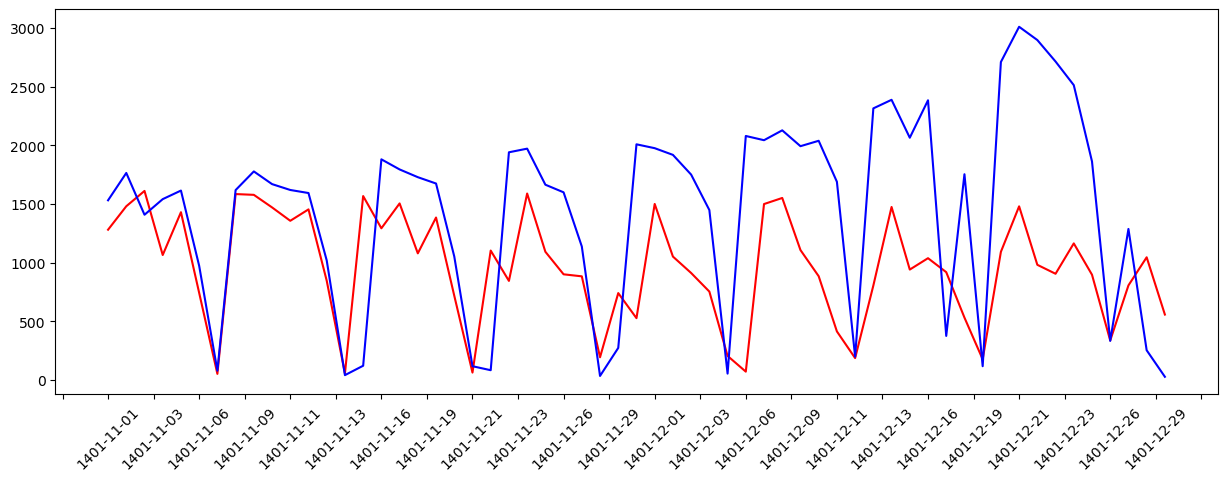

In [44]:
f, ax = plt.subplots(figsize=(15,5))
if cfg.validation_phase:
    ax.plot(m3_eval_dates, predict, color='r')
    ax.plot(m3_eval_dates, m3_eval_y, color='b')
else:
    ax.plot(m3_train_dates, predict, color='r')
    ax.plot(m3_train_dates, m3_train_y, color='b')

ax.xaxis.set_major_locator(plt.MaxNLocator(30))
plt.xticks(rotation = 45)
plt.show()

### using a Mix of M2 & M3 Data

In [45]:
# model config
n_estimators = 5000
es = 20
lr = 0.01
verbosity = True
if cfg.validation_phase:
    eval_set = [(m4_train_x, m3_train_y), (m4_eval_x, m4_eval_y)]
else:
    eval_set = [(m4_train_x, m4_train_y)]

In [46]:
xgbr = xgb.XGBRegressor(n_estimators=n_estimators, early_stopping_rounds=es, learning_rate=lr)
xgbr.fit(m4_train_x, m4_train_y,
        eval_set=eval_set,
        verbose=verbosity)

[0]	validation_0-rmse:1095.77806	validation_1-rmse:1661.17965
[1]	validation_0-rmse:1085.38317	validation_1-rmse:1650.05448
[2]	validation_0-rmse:1075.09274	validation_1-rmse:1639.05940
[3]	validation_0-rmse:1064.90572	validation_1-rmse:1628.19192
[4]	validation_0-rmse:1054.82068	validation_1-rmse:1617.45256
[5]	validation_0-rmse:1044.83720	validation_1-rmse:1606.83955
[6]	validation_0-rmse:1034.95122	validation_1-rmse:1595.80042
[7]	validation_0-rmse:1025.16656	validation_1-rmse:1585.43198
[8]	validation_0-rmse:1015.48231	validation_1-rmse:1574.68239
[9]	validation_0-rmse:1005.89591	validation_1-rmse:1564.05553
[10]	validation_0-rmse:996.39814	validation_1-rmse:1553.99758
[11]	validation_0-rmse:987.00337	validation_1-rmse:1543.61370
[12]	validation_0-rmse:977.69956	validation_1-rmse:1533.83671
[13]	validation_0-rmse:968.49375	validation_1-rmse:1523.74399
[14]	validation_0-rmse:959.37167	validation_1-rmse:1514.14549
[15]	validation_0-rmse:950.34946	validation_1-rmse:1504.23325
[16]	val

[132]	validation_0-rmse:330.71022	validation_1-rmse:1058.66143
[133]	validation_0-rmse:327.76557	validation_1-rmse:1056.10582
[134]	validation_0-rmse:324.85069	validation_1-rmse:1053.72908
[135]	validation_0-rmse:322.11579	validation_1-rmse:1052.59181
[136]	validation_0-rmse:319.25805	validation_1-rmse:1050.12121
[137]	validation_0-rmse:316.42367	validation_1-rmse:1047.67872
[138]	validation_0-rmse:313.62355	validation_1-rmse:1045.36826
[139]	validation_0-rmse:310.84658	validation_1-rmse:1043.01550
[140]	validation_0-rmse:308.09820	validation_1-rmse:1040.65752
[141]	validation_0-rmse:305.38270	validation_1-rmse:1038.42603
[142]	validation_0-rmse:302.69547	validation_1-rmse:1036.12686
[143]	validation_0-rmse:300.15490	validation_1-rmse:1035.26161
[144]	validation_0-rmse:297.52054	validation_1-rmse:1033.04480
[145]	validation_0-rmse:294.91223	validation_1-rmse:1030.92357
[146]	validation_0-rmse:292.32567	validation_1-rmse:1028.52527
[147]	validation_0-rmse:289.76578	validation_1-rmse:102

[264]	validation_0-rmse:113.48302	validation_1-rmse:920.10674
[265]	validation_0-rmse:112.67741	validation_1-rmse:919.65363
[266]	validation_0-rmse:111.86535	validation_1-rmse:919.17630
[267]	validation_0-rmse:111.02633	validation_1-rmse:918.72536
[268]	validation_0-rmse:110.22335	validation_1-rmse:918.31657
[269]	validation_0-rmse:109.39159	validation_1-rmse:917.88448
[270]	validation_0-rmse:108.63082	validation_1-rmse:917.44059
[271]	validation_0-rmse:107.81902	validation_1-rmse:917.20044
[272]	validation_0-rmse:107.01158	validation_1-rmse:916.78313
[273]	validation_0-rmse:106.19630	validation_1-rmse:916.37716
[274]	validation_0-rmse:105.38954	validation_1-rmse:915.97531
[275]	validation_0-rmse:104.60903	validation_1-rmse:915.59496
[276]	validation_0-rmse:103.81781	validation_1-rmse:915.30653
[277]	validation_0-rmse:103.03971	validation_1-rmse:914.93899
[278]	validation_0-rmse:102.26342	validation_1-rmse:914.63703
[279]	validation_0-rmse:101.49517	validation_1-rmse:914.33412
[280]	va

[399]	validation_0-rmse:47.27140	validation_1-rmse:880.79111
[400]	validation_0-rmse:46.97708	validation_1-rmse:880.67267
[401]	validation_0-rmse:46.73651	validation_1-rmse:880.52157
[402]	validation_0-rmse:46.43984	validation_1-rmse:880.40661
[403]	validation_0-rmse:46.14826	validation_1-rmse:880.30163
[404]	validation_0-rmse:45.93541	validation_1-rmse:880.14538
[405]	validation_0-rmse:45.65193	validation_1-rmse:880.04793
[406]	validation_0-rmse:45.41972	validation_1-rmse:879.83678
[407]	validation_0-rmse:45.13462	validation_1-rmse:879.71172
[408]	validation_0-rmse:44.85742	validation_1-rmse:879.61472
[409]	validation_0-rmse:44.65187	validation_1-rmse:879.40308
[410]	validation_0-rmse:44.38070	validation_1-rmse:879.30337
[411]	validation_0-rmse:44.10854	validation_1-rmse:879.19621
[412]	validation_0-rmse:43.88746	validation_1-rmse:878.99691
[413]	validation_0-rmse:43.61879	validation_1-rmse:878.90194
[414]	validation_0-rmse:43.35487	validation_1-rmse:878.81107
[415]	validation_0-rmse:

[534]	validation_0-rmse:23.63049	validation_1-rmse:869.68886
[535]	validation_0-rmse:23.52717	validation_1-rmse:869.62396
[536]	validation_0-rmse:23.44096	validation_1-rmse:869.57816
[537]	validation_0-rmse:23.35941	validation_1-rmse:869.53247
[538]	validation_0-rmse:23.27820	validation_1-rmse:869.48706
[539]	validation_0-rmse:23.17708	validation_1-rmse:869.44690
[540]	validation_0-rmse:23.09799	validation_1-rmse:869.40214
[541]	validation_0-rmse:22.99844	validation_1-rmse:869.35926
[542]	validation_0-rmse:22.91309	validation_1-rmse:869.32755
[543]	validation_0-rmse:22.83517	validation_1-rmse:869.28358
[544]	validation_0-rmse:22.75821	validation_1-rmse:869.23989
[545]	validation_0-rmse:22.66148	validation_1-rmse:869.25211
[546]	validation_0-rmse:22.56509	validation_1-rmse:869.21110
[547]	validation_0-rmse:22.48985	validation_1-rmse:869.16843
[548]	validation_0-rmse:22.41610	validation_1-rmse:869.12660
[549]	validation_0-rmse:22.32155	validation_1-rmse:869.09028
[550]	validation_0-rmse:

[669]	validation_0-rmse:14.15565	validation_1-rmse:865.84554
[670]	validation_0-rmse:14.12220	validation_1-rmse:865.80064
[671]	validation_0-rmse:14.06496	validation_1-rmse:865.78664
[672]	validation_0-rmse:14.01670	validation_1-rmse:865.78413
[673]	validation_0-rmse:13.98388	validation_1-rmse:865.74134
[674]	validation_0-rmse:13.94366	validation_1-rmse:865.74146
[675]	validation_0-rmse:13.90630	validation_1-rmse:865.73945
[676]	validation_0-rmse:13.85590	validation_1-rmse:865.71553
[677]	validation_0-rmse:13.80845	validation_1-rmse:865.67723
[678]	validation_0-rmse:13.77156	validation_1-rmse:865.67548
[679]	validation_0-rmse:13.73975	validation_1-rmse:865.63434
[680]	validation_0-rmse:13.69427	validation_1-rmse:865.63010
[681]	validation_0-rmse:13.64779	validation_1-rmse:865.59275
[682]	validation_0-rmse:13.61229	validation_1-rmse:865.58796
[683]	validation_0-rmse:13.56063	validation_1-rmse:865.56535
[684]	validation_0-rmse:13.52967	validation_1-rmse:865.52540
[685]	validation_0-rmse:

[804]	validation_0-rmse:9.44944	validation_1-rmse:863.90789
[805]	validation_0-rmse:9.42718	validation_1-rmse:863.89343
[806]	validation_0-rmse:9.39657	validation_1-rmse:863.88380
[807]	validation_0-rmse:9.36580	validation_1-rmse:863.87427
[808]	validation_0-rmse:9.34436	validation_1-rmse:863.86517
[809]	validation_0-rmse:9.31457	validation_1-rmse:863.85574
[810]	validation_0-rmse:9.28639	validation_1-rmse:863.84971
[811]	validation_0-rmse:9.25260	validation_1-rmse:863.85055
[812]	validation_0-rmse:9.22990	validation_1-rmse:863.83149
[813]	validation_0-rmse:9.20833	validation_1-rmse:863.81801
[814]	validation_0-rmse:9.17870	validation_1-rmse:863.80881
[815]	validation_0-rmse:9.15509	validation_1-rmse:863.80752
[816]	validation_0-rmse:9.13150	validation_1-rmse:863.79614
[817]	validation_0-rmse:9.10230	validation_1-rmse:863.78538
[818]	validation_0-rmse:9.08042	validation_1-rmse:863.77234
[819]	validation_0-rmse:9.05945	validation_1-rmse:863.75754
[820]	validation_0-rmse:9.02889	validati

[941]	validation_0-rmse:6.43830	validation_1-rmse:863.25475
[942]	validation_0-rmse:6.42003	validation_1-rmse:863.24733
[943]	validation_0-rmse:6.40524	validation_1-rmse:863.24700
[944]	validation_0-rmse:6.38610	validation_1-rmse:863.23414
[945]	validation_0-rmse:6.37151	validation_1-rmse:863.23362
[946]	validation_0-rmse:6.35599	validation_1-rmse:863.23322
[947]	validation_0-rmse:6.34320	validation_1-rmse:863.23033
[948]	validation_0-rmse:6.32263	validation_1-rmse:863.22903
[949]	validation_0-rmse:6.30632	validation_1-rmse:863.22906
[950]	validation_0-rmse:6.28782	validation_1-rmse:863.22401
[951]	validation_0-rmse:6.26892	validation_1-rmse:863.22420
[952]	validation_0-rmse:6.25482	validation_1-rmse:863.22390
[953]	validation_0-rmse:6.23978	validation_1-rmse:863.22354
[954]	validation_0-rmse:6.22188	validation_1-rmse:863.22142
[955]	validation_0-rmse:6.20178	validation_1-rmse:863.22196
[956]	validation_0-rmse:6.18702	validation_1-rmse:863.22164
[957]	validation_0-rmse:6.17084	validati

XGBRegressor(base_score=None, booster=None, callbacks=None,
             colsample_bylevel=None, colsample_bynode=None,
             colsample_bytree=None, early_stopping_rounds=20,
             enable_categorical=False, eval_metric=None, feature_types=None,
             gamma=None, gpu_id=None, grow_policy=None, importance_type=None,
             interaction_constraints=None, learning_rate=0.01, max_bin=None,
             max_cat_threshold=None, max_cat_to_onehot=None,
             max_delta_step=None, max_depth=None, max_leaves=None,
             min_child_weight=None, missing=nan, monotone_constraints=None,
             n_estimators=5000, n_jobs=None, num_parallel_tree=None,
             predictor=None, random_state=None, ...)

In [47]:
if cfg.validation_phase:
    predict = xgbr.predict(m4_eval_x)
else:
    predict = xgbr.predict(m4_train_x)

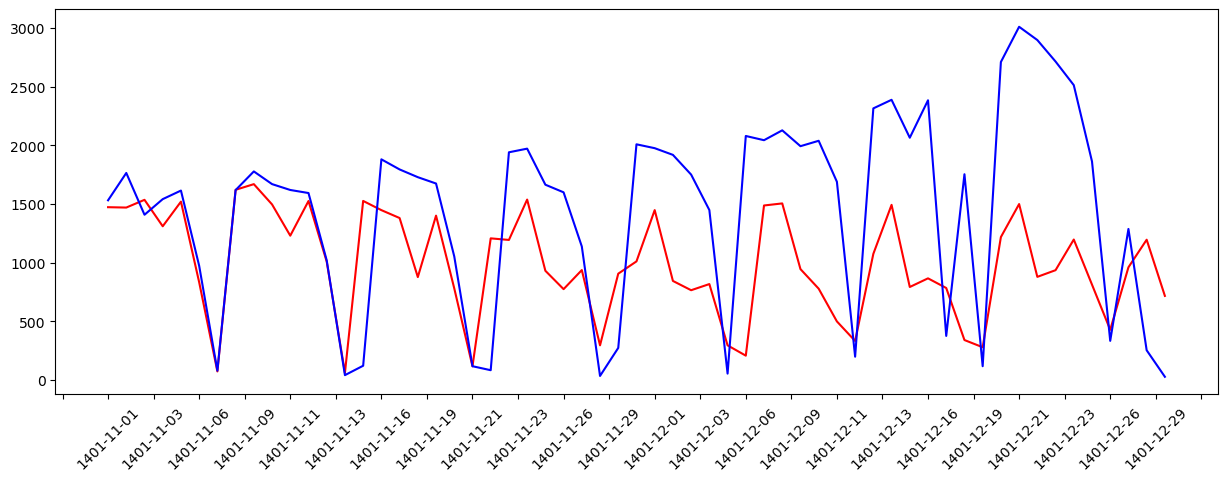

In [48]:
f, ax = plt.subplots(figsize=(15,5))
if cfg.validation_phase:
    ax.plot(m4_eval_dates, predict, color='r')
    ax.plot(m4_eval_dates, m4_eval_y, color='b')
else:
    ax.plot(m4_train_dates, predict, color='r')
    ax.plot(m4_train_dates, m4_train_y, color='b')

ax.xaxis.set_major_locator(plt.MaxNLocator(30))
plt.xticks(rotation = 45)
plt.show()

## Neural Network Model

### using M3 Data

In [49]:
tf.keras.backend.clear_session()

es = tf.keras.callbacks.EarlyStopping(
    monitor='val_loss',
    min_delta=0,
    patience=50,
    verbose=0,
    mode='auto',
    baseline=None,
    restore_best_weights=True
)

if cfg.validation_phase:
    validation_data=(m3_eval_x, m3_eval_y)
else:
    validation_data = None

In [50]:
LSTM_model = Sequential([
    layers.LSTM(128, return_sequences=True, input_shape=(window_size-1,1)),
#     layers.LSTM(64, return_sequences=True),
    layers.LSTM(64, return_sequences=False),
#     layers.Dense(64, activation='relu'),
    layers.Dense(64, activation='relu'),
    layers.Dense(64, activation='relu'),
    layers.Dense(32, activation='relu'),
    layers.Dense(1)
])

init_ws = LSTM_model.get_weights()
LSTM_model.compile(loss='mse', optimizer=optimizers.Adam(0.001), metrics=['mean_absolute_error'])
history = LSTM_model.fit(m3_train_x, m3_train_y, validation_data=validation_data, epochs=1000, callbacks=[es])
print('-'*100)
print(min(history.history['loss']),'-------', min(history.history['val_loss']))
trained_ws = LSTM_model.get_weights()

Epoch 1/1000
9/9 [==============================] - 4s 66ms/step - loss: 1223111.2500 - mean_absolute_error: 983.5636 - val_loss: 2791559.5000 - val_mean_absolute_error: 1450.1731
Epoch 2/1000
9/9 [==============================] - 0s 17ms/step - loss: 1216489.2500 - mean_absolute_error: 980.2563 - val_loss: 2777689.2500 - val_mean_absolute_error: 1445.3842
Epoch 3/1000
9/9 [==============================] - 0s 13ms/step - loss: 1203858.3750 - mean_absolute_error: 973.8195 - val_loss: 2751581.0000 - val_mean_absolute_error: 1436.3245
Epoch 4/1000
9/9 [==============================] - 0s 13ms/step - loss: 1180937.6250 - mean_absolute_error: 962.1529 - val_loss: 2705572.2500 - val_mean_absolute_error: 1420.3254
Epoch 5/1000
9/9 [==============================] - 0s 12ms/step - loss: 1142271.5000 - mean_absolute_error: 942.8625 - val_loss: 2631649.7500 - val_mean_absolute_error: 1396.3264
Epoch 6/1000
9/9 [==============================] - 0s 10ms/step - loss: 1082114.7500 - mean_absolut

Epoch 47/1000
9/9 [==============================] - 0s 10ms/step - loss: 123186.6406 - mean_absolute_error: 271.8738 - val_loss: 658019.1250 - val_mean_absolute_error: 711.1306
Epoch 48/1000
9/9 [==============================] - 0s 10ms/step - loss: 102192.6172 - mean_absolute_error: 249.5954 - val_loss: 641405.9375 - val_mean_absolute_error: 705.8828
Epoch 49/1000
9/9 [==============================] - 0s 10ms/step - loss: 88307.7422 - mean_absolute_error: 231.4912 - val_loss: 620318.6250 - val_mean_absolute_error: 687.5980
Epoch 50/1000
9/9 [==============================] - 0s 10ms/step - loss: 84227.1406 - mean_absolute_error: 226.7732 - val_loss: 633646.8750 - val_mean_absolute_error: 697.0224
Epoch 51/1000
9/9 [==============================] - 0s 9ms/step - loss: 81333.7891 - mean_absolute_error: 220.9807 - val_loss: 606252.3125 - val_mean_absolute_error: 678.9307
Epoch 52/1000
9/9 [==============================] - 0s 10ms/step - loss: 75065.0000 - mean_absolute_error: 206.07

9/9 [==============================] - 0s 10ms/step - loss: 50165.0508 - mean_absolute_error: 156.5465 - val_loss: 543146.8750 - val_mean_absolute_error: 616.0963
Epoch 94/1000
9/9 [==============================] - 0s 10ms/step - loss: 51399.2461 - mean_absolute_error: 158.2772 - val_loss: 560448.5000 - val_mean_absolute_error: 631.9210
Epoch 95/1000
9/9 [==============================] - 0s 11ms/step - loss: 53695.6914 - mean_absolute_error: 161.6528 - val_loss: 550248.5625 - val_mean_absolute_error: 607.3539
Epoch 96/1000
9/9 [==============================] - 0s 11ms/step - loss: 55877.2773 - mean_absolute_error: 162.5851 - val_loss: 585204.6250 - val_mean_absolute_error: 652.0230
Epoch 97/1000
9/9 [==============================] - 0s 10ms/step - loss: 50356.0859 - mean_absolute_error: 155.1283 - val_loss: 560926.8750 - val_mean_absolute_error: 631.7502
Epoch 98/1000
9/9 [==============================] - 0s 10ms/step - loss: 48523.0664 - mean_absolute_error: 149.3805 - val_loss: 

9/9 [==============================] - 0s 11ms/step - loss: 40230.3789 - mean_absolute_error: 128.0868 - val_loss: 531778.3750 - val_mean_absolute_error: 596.7990
Epoch 140/1000
9/9 [==============================] - 0s 10ms/step - loss: 40060.5273 - mean_absolute_error: 127.4678 - val_loss: 542924.8125 - val_mean_absolute_error: 613.3464
Epoch 141/1000
9/9 [==============================] - 0s 10ms/step - loss: 41114.5430 - mean_absolute_error: 128.0113 - val_loss: 538277.5625 - val_mean_absolute_error: 609.7604
Epoch 142/1000
9/9 [==============================] - 0s 10ms/step - loss: 41427.1836 - mean_absolute_error: 130.5546 - val_loss: 535113.7500 - val_mean_absolute_error: 597.4925
Epoch 143/1000
9/9 [==============================] - 0s 10ms/step - loss: 39694.7383 - mean_absolute_error: 128.7888 - val_loss: 528988.3125 - val_mean_absolute_error: 592.9996
Epoch 144/1000
9/9 [==============================] - 0s 10ms/step - loss: 39514.9805 - mean_absolute_error: 126.4628 - val_l

9/9 [==============================] - 0s 11ms/step - loss: 31431.8203 - mean_absolute_error: 113.1671 - val_loss: 532549.6250 - val_mean_absolute_error: 593.5448
Epoch 186/1000
9/9 [==============================] - 0s 11ms/step - loss: 35594.8008 - mean_absolute_error: 121.5916 - val_loss: 495917.1875 - val_mean_absolute_error: 551.9291
Epoch 187/1000
9/9 [==============================] - 0s 10ms/step - loss: 31871.1426 - mean_absolute_error: 109.3344 - val_loss: 507456.9375 - val_mean_absolute_error: 567.4510
Epoch 188/1000
9/9 [==============================] - 0s 9ms/step - loss: 28553.0781 - mean_absolute_error: 101.3080 - val_loss: 501337.0938 - val_mean_absolute_error: 553.3943
Epoch 189/1000
9/9 [==============================] - 0s 9ms/step - loss: 32637.1406 - mean_absolute_error: 110.6906 - val_loss: 511204.5312 - val_mean_absolute_error: 545.8884
Epoch 190/1000
9/9 [==============================] - 0s 10ms/step - loss: 31300.7734 - mean_absolute_error: 107.6791 - val_los

In [51]:
p=LSTM_model.predict(m3_eval_x)

2/2 [==============================] - 0s 5ms/step


In [52]:
np.sqrt(mean_squared_error(p, m3_eval_y))

697.37427

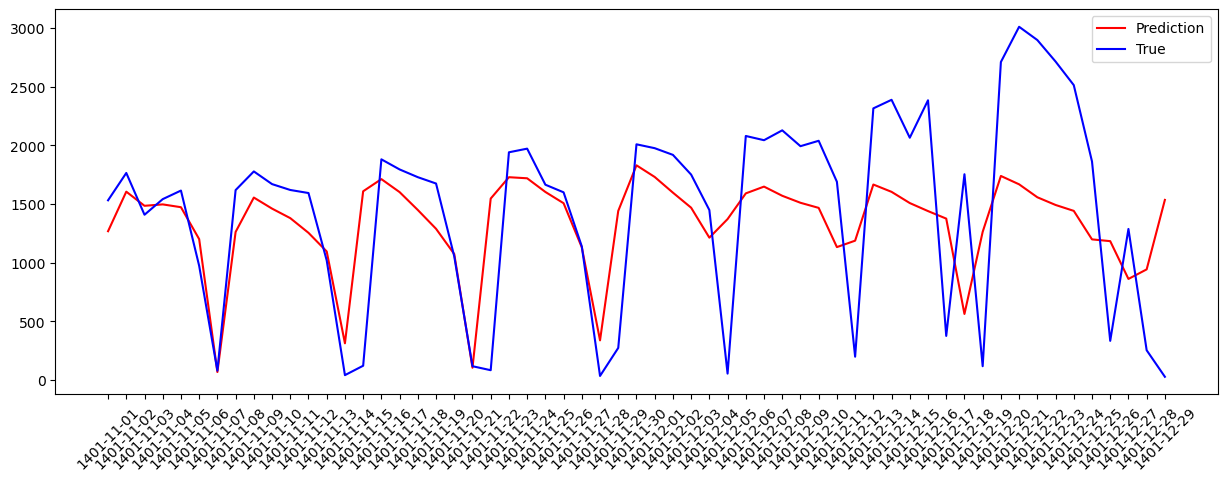

In [53]:
f, ax = plt.subplots(figsize=(15,5))
if cfg.validation_phase:
    ax.plot(m3_eval_dates, p, color='r')
    ax.plot(m3_eval_dates, m3_eval_y, color='b')
else:
    ax.plot(m3_train_dates, p, color='r')
    ax.plot(m3_train_dates, m3_train_y, color='b')
ax.legend(['Prediction', 'True'])
plt.xticks(rotation = 45)
plt.show()

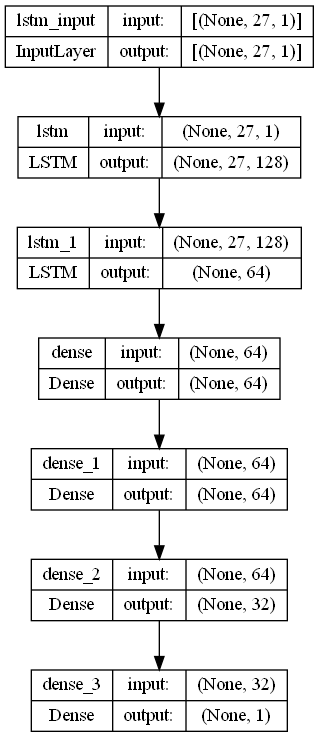

In [54]:
tf.keras.utils.plot_model(
    LSTM_model,
    show_shapes=True,
    show_dtype=False,
    show_layer_names=True,
    rankdir='TB',
    expand_nested=False,
    dpi=96,
    layer_range=None,
    show_layer_activations=False,
)


### using a Mix of M2 & M3 Data

In [89]:
LSTM_model.set_weights(init_ws)
D_model = Sequential([
    layers.Dense(64, activation='relu', input_shape=(m2_train_x.shape[1],)),
    layers.Dense(32, activation='relu'),
    layers.Dense(32, activation='relu'),
])

L_model = Model(inputs=LSTM_model.input, outputs=LSTM_model.get_layer(index=-4).output)

inputs = layers.concatenate([D_model.output, L_model.output])
l = layers.Dense(32, activation='relu')(inputs)
l = layers.Dense(1, activation='linear')(l)

MIX_model = Model(inputs=[D_model.input, L_model.input], outputs=l)

In [90]:
MIX_model.summary()

Model: "model_7"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 dense_19_input (InputLayer)    [(None, 4)]          0           []                               
                                                                                                  
 lstm_input (InputLayer)        [(None, 27, 1)]      0           []                               
                                                                                                  
 dense_19 (Dense)               (None, 64)           320         ['dense_19_input[0][0]']         
                                                                                                  
 lstm (LSTM)                    (None, 27, 128)      66560       ['lstm_input[0][0]']             
                                                                                            

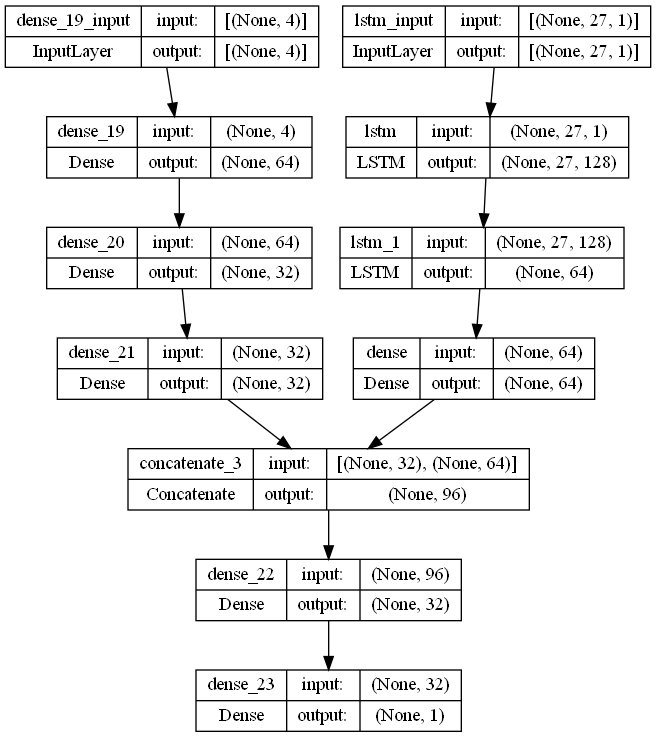

In [91]:
tf.keras.utils.plot_model(
    MIX_model,
    show_shapes=True,
    show_dtype=False,
    show_layer_names=True,
    rankdir='TB',
    expand_nested=False,
    dpi=96,
    layer_range=None,
    show_layer_activations=False,
)


In [92]:
validation_data = ([m2_eval_x, m3_eval_x], m4_eval_y)
MIX_model.compile(loss='mse', optimizer=optimizers.Adam(0.0008), metrics=['mean_absolute_error'])
history = MIX_model.fit([m2_train_x.loc[idx], m3_train_x], m4_train_y, validation_data =validation_data ,epochs=1000, callbacks=[es])
print('-'*100)
print(min(history.history['loss']),'-------', min(history.history['val_loss']))



Epoch 1/1000
9/9 [==============================] - 2s 71ms/step - loss: 1220859.5000 - mean_absolute_error: 982.5055 - val_loss: 2780109.0000 - val_mean_absolute_error: 1446.2161
Epoch 2/1000
9/9 [==============================] - 0s 19ms/step - loss: 1213106.5000 - mean_absolute_error: 978.7370 - val_loss: 2759877.5000 - val_mean_absolute_error: 1439.2023
Epoch 3/1000
9/9 [==============================] - 0s 14ms/step - loss: 1201787.1250 - mean_absolute_error: 973.0115 - val_loss: 2726734.7500 - val_mean_absolute_error: 1427.6451
Epoch 4/1000
9/9 [==============================] - 0s 11ms/step - loss: 1183454.8750 - mean_absolute_error: 963.9296 - val_loss: 2675345.2500 - val_mean_absolute_error: 1410.5333
Epoch 5/1000
9/9 [==============================] - 0s 11ms/step - loss: 1155008.5000 - mean_absolute_error: 949.9020 - val_loss: 2597169.0000 - val_mean_absolute_error: 1385.8250
Epoch 6/1000
9/9 [==============================] - 0s 11ms/step - loss: 1111932.3750 - mean_absolut

Epoch 47/1000
9/9 [==============================] - 0s 11ms/step - loss: 254268.3906 - mean_absolute_error: 414.2068 - val_loss: 702457.0625 - val_mean_absolute_error: 709.4493
Epoch 48/1000
9/9 [==============================] - 0s 11ms/step - loss: 253487.5625 - mean_absolute_error: 415.1702 - val_loss: 701648.2500 - val_mean_absolute_error: 711.7852
Epoch 49/1000
9/9 [==============================] - 0s 10ms/step - loss: 250280.0625 - mean_absolute_error: 411.1139 - val_loss: 698495.4375 - val_mean_absolute_error: 705.8656
Epoch 50/1000
9/9 [==============================] - 0s 11ms/step - loss: 246280.8906 - mean_absolute_error: 400.3505 - val_loss: 692180.6875 - val_mean_absolute_error: 692.7280
Epoch 51/1000
9/9 [==============================] - 0s 11ms/step - loss: 239954.1250 - mean_absolute_error: 397.8998 - val_loss: 687877.9375 - val_mean_absolute_error: 700.4391
Epoch 52/1000
9/9 [==============================] - 0s 11ms/step - loss: 234893.1250 - mean_absolute_error: 3

9/9 [==============================] - 0s 10ms/step - loss: 78981.7578 - mean_absolute_error: 179.7562 - val_loss: 425883.7500 - val_mean_absolute_error: 527.6157
Epoch 94/1000
9/9 [==============================] - 0s 10ms/step - loss: 71537.6094 - mean_absolute_error: 172.6188 - val_loss: 455012.3438 - val_mean_absolute_error: 560.2529
Epoch 95/1000
9/9 [==============================] - 0s 10ms/step - loss: 69543.1484 - mean_absolute_error: 170.0725 - val_loss: 452946.4375 - val_mean_absolute_error: 551.6190
Epoch 96/1000
9/9 [==============================] - 0s 10ms/step - loss: 68225.6484 - mean_absolute_error: 165.8386 - val_loss: 456808.0625 - val_mean_absolute_error: 551.0800
Epoch 97/1000
9/9 [==============================] - 0s 10ms/step - loss: 67057.0703 - mean_absolute_error: 161.6345 - val_loss: 474040.0625 - val_mean_absolute_error: 564.9802
Epoch 98/1000
9/9 [==============================] - 0s 10ms/step - loss: 68800.0469 - mean_absolute_error: 168.2552 - val_loss: 

In [93]:
p=MIX_model.predict([m2_eval_x.loc[idx], m3_eval_x])
np.sqrt(mean_squared_error(m4_eval_y, p))

2/2 [==============================] - 1s 5ms/step


646.618

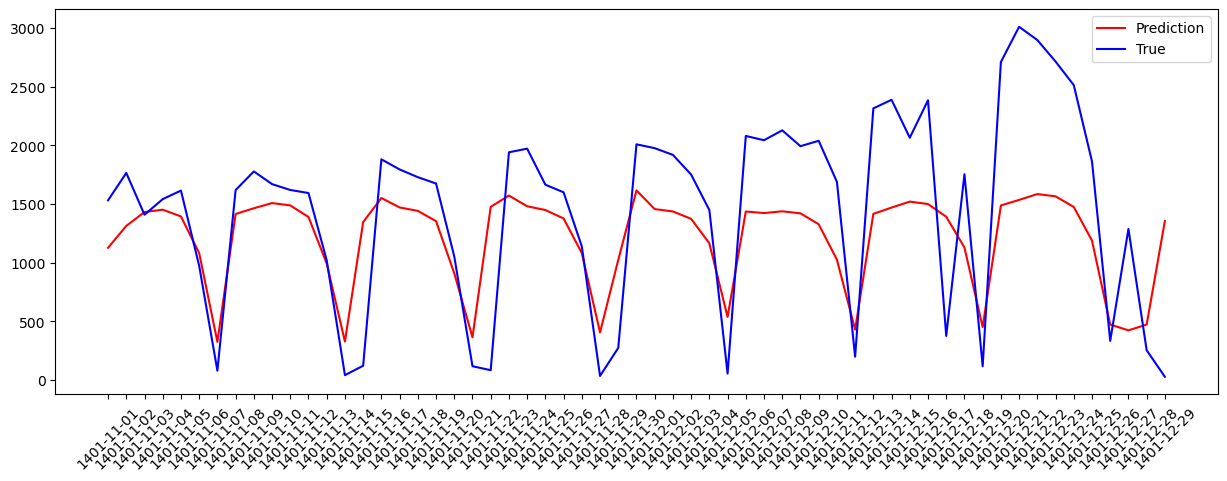

In [94]:
f, ax = plt.subplots(figsize=(15,5))
if cfg.validation_phase:
    ax.plot(m4_eval_dates, p, color='r')
    ax.plot(m4_eval_dates, m4_eval_y, color='b')
else:
    ax.plot(m4_train_dates, p, color='r')
    ax.plot(m4_train_dates, m4_train_y, color='b')
ax.legend(['Prediction', 'True'])
plt.xticks(rotation = 45)
plt.show()

# Prediction

In [95]:
lis = []
for i in range(0,93):
    lis.append(jdatetime.date(1402,1,1) + jdatetime.timedelta(days=i))
m2_test_df = pd.DataFrame()
m2_test_df['date'] = lis
m2_test_df = m2_test_df.set_index('date')

day_of_month = np.array([i.day for i in m2_test_df.index.values])
month = np.array([i.month for i in m2_test_df.index.values])
year = np.array([i.year for i in m2_test_df.index.values])
day_of_week = (day_of_month+1)%7 # saturday is 0 and friday is 6
week = np.array(range(2,95))//7 + 1
for feat, name in zip([day_of_month,month,day_of_week,week], ['day_of_month','month','day_of_week','week']):
    m2_test_df[name] = feat
    
m2_test_df[m3_df.columns[1:]] = np.NAN
m2_test_df.iloc[0,4:-1] = m4_df.iloc[-1,6:]
m2_test_df.iloc[0,-1] = m4_df.iloc[-1,0]

In [96]:
pred = []
for i in range(1, m2_test_df.shape[0]):
    p = MIX_model.predict([m2_test_df.iloc[i-1][:4].values.reshape(1,-1), m2_test_df.iloc[i-1][4:].values.reshape(1,-1)])
    pred.append(tf.nn.relu(p[0,0]).numpy())
    m2_test_df.iloc[i,-1] = tf.nn.relu(p[0,0]).numpy()
    m2_test_df.iloc[i,4:-1] = m2_test_df.iloc[i-1,5:]
pred.append(np.NAN)
m2_test_df['pred'] = pred

1/1 [==============================] - 0s 17ms/step


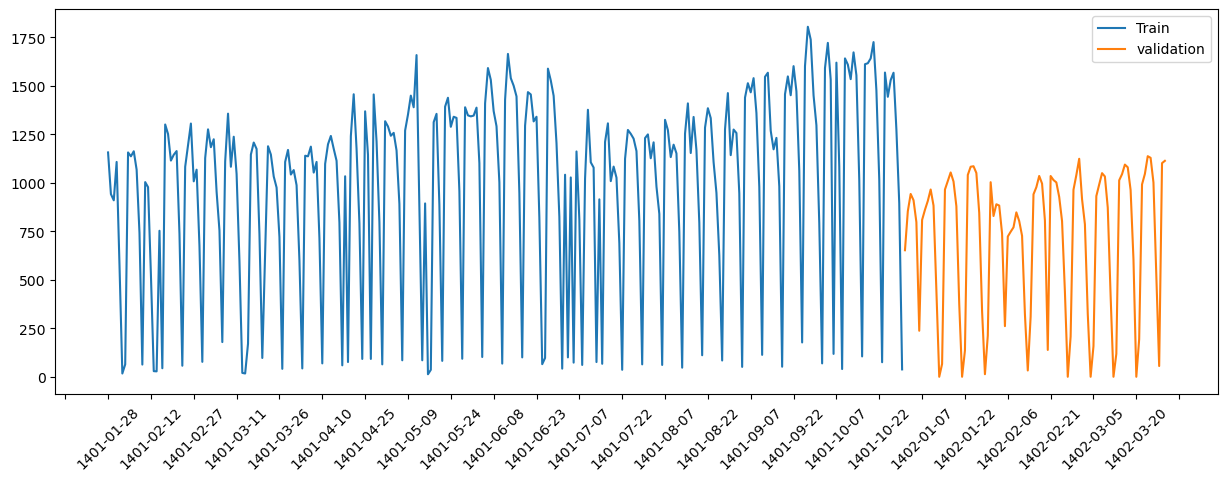

In [97]:
m2_test_df.index = [str(i) for i in m2_test_df.index]
f, ax = plt.subplots(figsize=(15,5))
ax.plot(m3_train_dates, m3_train_y)
ax.plot(m2_test_df['pred'].index, m2_test_df['pred'].values)

ax.xaxis.set_major_locator(plt.MaxNLocator(30))
plt.xticks(rotation=45)
plt.legend(['Train', 'validation','Test'])
plt.show()

In [100]:
m2_test_df['pred']

1402-01-01     652.562927
1402-01-02     853.857544
1402-01-03     942.809387
1402-01-04     910.538879
1402-01-05     797.508362
                 ...     
1402-03-27     522.794067
1402-03-28      55.489887
1402-03-29    1101.873901
1402-03-30    1113.702148
1402-03-31            NaN
Name: pred, Length: 93, dtype: float64